# "Куда ты тропинка меня привела?":  моделируем переходы читателя по  телеграм-каналам с помощью Марковской цепи

Представим себе человека, который читает телеграм-канал i, а затем случайным образом переходит для чтения в канал j, который упоминается в канале i. Канал может упоминаться в виде ссылки вида @ или t.me, а также репоста материала. Если мы представим каналы i и j узлами графа, то связь i с j  назовем ребром i → j. После перехода в канал j, человек повторяет процесс случайного выбора нового канала j → k. 

В нашем случае дано 217 телеграм-каналов аналитической тематики (от анализа данных до визуализации), связанных 1428 упоминаниями (подробности в [статье](https://leftjoin.ru/all/analytical-telegram-channels-graph/)). 

Где с наибольшей вероятностью окажется человек, если будет переходить итеративно по всем упоминаниям в каналах?  



In [ ]:
# загружаем нужные библиотеки
import sys
import numpy as np
import scipy as sp
import scipy.sparse
import pandas as pd

import time
from io import BytesIO
import requests

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display, Markdown 

## 1: Загрузка и исследование данных


Загружаем данные каналов из Google Sheets в следующем формате:
* id - уникальный идентификатор канала
* link - адрес канала в телеграм
* name - название канала
* description - описание

In [ ]:
req = requests.get('https://docs.google.com/spreadsheets/d/e/2PACX-1vRllDtCYQzdVoxmOBC4Qt0T8NsVYBHQhg_kXL2Mv6f25CmJM5HFaxCGCW7w5PSCR0jU78ddf_VUk7jQ/pub?output=csv')
data = req.content
nodes = pd.read_csv(BytesIO(data), encoding='utf-8-sig')
print("Число загруженных каналов: {}".format (len(nodes)))
nodes.head()

Число загруженных каналов: 217


,id,link,name,description
0,1407735984,https://t.me/leftjoin,LEFT JOIN,Make data work. Канал об аналитике блога leftj...
1,1387835436,https://t.me/nastengraph,настенька и графики,Тут датавиз аналитика и всякое полезное и инте...
2,1329188755,https://t.me/rockyourdata,Инжиниринг Данных,Канал для всех кто интересуется или работает с...
3,1195518065,https://t.me/data_csv,data.csv,Блог о журналистике данных и дата-сторителлинг...
4,1490689117,https://t.me/revealthedata,Reveal the Data,Канал Ромы Бунина про визуализацию данных разв...


Загружаем данные связей каналов (упоминаний одним каналом других) в следующем формате:
* source - идентификатор канала-источника
* target - идентификатор целевого канала
* count - количество упоминаний целевого канала в канале-источнике

In [ ]:
req = requests.get('https://docs.google.com/spreadsheets/d/e/2PACX-1vR5iptxPqQZXV6E5wSjd42bIzhTU9XV6sN-A9oc4P6mkKXb88nm9Fza5GmdQ8VF98yIGRNPJR4ktuHI/pub?output=csv')
data = req.content
edges = pd.read_csv(BytesIO(data))
print("Число загруженных упоминаний: {}".format (len(edges)))
edges.head()

Число загруженных упоминаний: 1428


,source,target,count
0,1004393721,1430200876,2
1,1004393721,1490689117,10
2,1004393721,1407735984,3
3,1004393721,1462487554,1
4,1004393721,1329188755,1


Получим топ-10 каналов по количеству упоминаний других каналов. 

In [ ]:
sources = edges[['source', 'count']].groupby('source', as_index=False).count()
sources_top = sources.sort_values(by='count', ascending=False)
sources_top.rename(columns={'source': 'id'}, inplace=True)
sources_top=sources_top.merge(nodes, on="id", how="left")
#убираем лишние колонки
del(sources_top['link'])
del(sources_top['description'])
#выводим результат
sources_top.head(10)

,id,count,name
0,1004393721,59,Интернет-аналитика
1,1294635786,51,Data Events
2,1490689117,48,Reveal the Data
3,1281187831,46,RTD: Ссылки и репосты
4,1453092978,42,Аналитика. Это просто
5,1119907458,35,Datalytics
6,1329188755,33,Инжиниринг Данных
7,1137067206,32,Epic Growth — рост продуктов продакт-менеджме...
8,1407735984,28,LEFT JOIN
9,1334049717,28,Аналитика для всех желающих


Получим топ-10 каналов, на которые больше всего ссылаются.

In [ ]:
targets = edges[['target', 'count']].groupby('target', as_index=False).count()
targets_top = targets.sort_values(by='count', ascending=False)
targets_top.rename(columns={'target': 'id'}, inplace=True)
targets_top=targets_top.merge(nodes, on="id", how="left")
#убираем лишние колонки
del(targets_top['link'])
del(targets_top['description'])
#выводим результат
targets_top.head(10)

,id,count,name
0,1329188755,44,Инжиниринг Данных
1,1490689117,40,Reveal the Data
2,1004393721,37,Интернет-аналитика
3,1109735806,31,Чартомойка
4,1117681513,26,Дата-сторителлинг
5,1407735984,26,LEFT JOIN
6,1181269908,24,Дашбордец
7,1387835436,22,настенька и графики
8,1392357804,21,BigQuery Insights
9,1119907458,21,Datalytics


Посмотрим ТОП10 каналов по числу любых связей (входящих и исходящих). Этот результат был ранее представлен в [материале про графы](https://leftjoin.ru/all/analytical-telegram-channels-graph/). 

In [ ]:
# переименовываем колонки для объединения
q1 = sources_top.copy()
q1.rename(columns={'count': 'count_out'}, inplace=True)
q2 = targets_top.copy()
q2.rename(columns={'count': 'count_in'}, inplace=True)

# объединяем
q1 = q1.merge(q2, on=['id', 'name'] , how="inner")

# считаем общее число связей
q1['count_full'] = q1['count_out'] + q1['count_in']

# выводим ТОП 10
q1 = q1.sort_values(by='count_full', ascending=False)
q1[['id','name', 'count_full']].head(10)


,id,name,count_full
0,1004393721,Интернет-аналитика,96
2,1490689117,Reveal the Data,88
6,1329188755,Инжиниринг Данных,77
1,1294635786,Data Events,69
5,1119907458,Datalytics,56
14,1109735806,Чартомойка,55
8,1407735984,LEFT JOIN,54
3,1281187831,RTD: Ссылки и репосты,50
7,1137067206,Epic Growth — рост продуктов продакт-менеджме...,50
12,1181269908,Дашбордец,49


## 2: Марковская цепь: немного теории

Марковская цепь (Markov Chain) - последовательность случайных событий с конечным или счётным числом исходов, где вероятность наступления каждого события зависит только от состояния, достигнутого в предыдущем событии. Характеризуется тем свойством, что, говоря нестрого, при фиксированном настоящем будущее независимо от прошлого. 

Термин получил название по имени выдающегося русского математика А.А.Маркова (1856-1922), впервые начавшего изучение вероятностной связи случайных величин и создавшего теорию, которую можно назвать "динамикой вероятностей".

Прежде чем дать описание общей схемы, обратимся к простому примеру. Предположим, что речь идет о последовательных бросаниях монеты при игре "в орлянку "; монета бросается в условные моменты времени _t = 0, 1, ..._ и на каждом шаге игрок может выиграть ±1 с одинаковой вероятностью 1/2, таким образом в момент t его суммарный выигрыш есть случайная величина _ξ(t)_ с возможными значениями _j = 0, ±1, ..._
При условии, что _ξ(t) = k_, на следующем шаге выигрыш будет уже равен _ξ(t+1) = k ± 1_, принимая указанные значения _j = k ± 1_ c одинаковой вероятностью 1/2. Условно можно сказать, что здесь с соответствующей вероятностью происходит переход из состояния _ξ(t) = k_ в состояние _ξ(t+1) = k ± 1_.

Обобщая этот пример, можно представить себе "систему" со счетным числом возможных "фазовых" состояний, которая с течением дискретного времени _t = 0, 1, ..._ случайно переходит из состояния в состояние.
Пусть ξ(t) есть ее положение в момент t в результате цепочки случайных переходов

$$ξ(0) - ξ(1) - ... - ξ(t) - ... (1)$$

Формально обозначим все возможные состояния целыми _i = 0, ±1, ..._ Предположим, что при известном состоянии _ξ(t) = k_ на следующем шаге система переходит в состояние _ξ(t+1) = j_ с условной вероятностью

$$P_{k, j} = P(ξ(t+1) = j|ξ(t) = k) ...(2)$$

независимо от ее поведения в прошлом, точнее, независимо от цепочки переходов (1) до момента t:

$$P(ξ(t+1) = j|ξ(0) = i, ..., ξ(t) = k) = P(ξ(t+1) = j|ξ(t) = k)(3)$$ 

при всех _t, k, j_ ... - марковское свойство.

Такую вероятностную схему называют однородной цепью Маркова со счетным числом состояний - ее однородность состоит в том, что определенные в (2) переходные вероятности $P_{k, j}, \sum_j P_{k, j} = 1$, k = 0, ±1, ..., не зависят от времени, т.е. _P(ξ(t+1) = j|ξ(t) = k) =_ $P_{i, j}$ - матрица вероятностей перехода за один шаг не зависит от n.

Благодаря сравнительной простоте и наглядности математического аппарата, высокой достоверности и точности получаемых решений, особое внимание Марковские цепи приобрели у специалистов, занимающихся исследованием операций и теорией принятия оптимальных решений.

## 3: Вариант расчета вероятности перехода, при котором упоминание канала другим каналом равновероятно


Для построения матрицы вероятностей перехода $P$ будем использовать возможности матриц из библиотеки SciPy.  

Для построения матрицы нужно выполнить следующее:

1. _Связать идентификаторы каналов с индексами матрицы._ `m`-к-`n` матрица в SciPy использует значения 0, 1, ..., `m`-1 и 0, ..., `n`-1 в индексах строк и столбцов.
2. _Задать вероятности перехода или веса $p_{ij}$._ Рассмотрим вариант расчета вероятности перехода, при котором упоминание канала другим каналом равновероятно. 

Добавляем новую колонку с id канала-источника

In [ ]:
source_indices = nodes[['id']].rename(columns={'id': 'source'})
source_indices['source_index'] = nodes.index
                               
if 'source_index' in edges.columns:
    del edges['source_index']
    
edges = edges.merge(source_indices, on='source', how='left')
edges.head()

,source,target,count,source_index
0,1004393721,1430200876,2,16
1,1004393721,1490689117,10,16
2,1004393721,1407735984,3,16
3,1004393721,1462487554,1,16
4,1004393721,1329188755,1,16


Аналогично повторяем для id целевого канала

In [ ]:
dest_indices = nodes[['id']].rename(columns={'id': 'target'})
dest_indices['target_index'] = nodes.index

if 'target_index' in edges.columns:
    del edges['target_index']
    
edges = edges.merge(dest_indices, on='target', how='left')
edges.head()

,source,target,count,source_index,target_index
0,1004393721,1430200876,2,16,9
1,1004393721,1490689117,10,16,4
2,1004393721,1407735984,3,16,0
3,1004393721,1462487554,1,16,5
4,1004393721,1329188755,1,16,2


Добавим новый столбец `OUTDEGREE`, в котором будет хранится общее число каналов, упомянутых в каждом канале-источнике.  

In [ ]:
if 'outdegree' in edges:
    del edges['outdegree']

degree = edges[['source','count']].groupby(by='source').count()
degree.rename(columns={'count': 'outdegree'}, inplace=True)

edges = edges.merge(degree, on='source', how='left')

Сформируем столбец `WEIGHT`, который будет содержать значения вероятности перехода из канала-источника в целевой канал. Величину вероятности примем равной обратному значению от количества упомянутых каналов (считаем, что читатель может равновероятно перейти в один из упомянутых каналов)

In [ ]:
if 'weight' in edges:
    del edges['weight']

edges['weight'] = 1.0 / edges['outdegree']

edges.head(5)

,source,target,count,source_index,target_index,outdegree,weight
0,1004393721,1430200876,2,16,9,59,0.016949
1,1004393721,1490689117,10,16,4,59,0.016949
2,1004393721,1407735984,3,16,0,59,0.016949
3,1004393721,1462487554,1,16,5,59,0.016949
4,1004393721,1329188755,1,16,2,59,0.016949


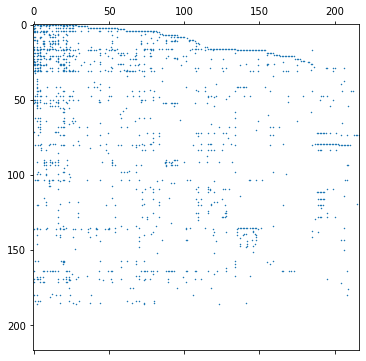

In [ ]:
from scipy.sparse import coo_matrix

def spy(A, figsize=(6, 6), markersize=0.5):
    fig = plt.figure(figsize=figsize)
    plt.spy(A, markersize=markersize)
    plt.show()

# размерность матрицы равна количеству каналов
n_ids = nodes.index.max() + 1

P = coo_matrix((edges['weight'], (edges['source_index'], edges['target_index'])), shape=(n_ids, n_ids))

# визуализируем матрицу
spy(P)

Задаем начальное состояние `x0` в момент времени $t=0$ 

In [ ]:
x0 = np.zeros(n_ids)
x0[np.unique(edges['source_index'])]=1/len(np.unique(edges['source_index']))

Используем матрицу переходов `P`, начальное состояние `x0`, и число переходов `t_max` в функции `eval_markov_chain(P, x0, t_max)` которая вычисляет и возвращает $x(t_{\textrm{max}})$. 
Используя результат работы функции, выведем ТОП10 каналов с наибольшей вероятностью попадания в них после `t_max` переходов.

In [ ]:
def eval_markov_chain(P, x0, t_max):
    x = x0
    for _ in range(t_max):
        x = P.transpose()@x    
    return x
    
T_MAX = 50
x = eval_markov_chain(P, x0, T_MAX)

ranks = np.argsort(-x)
top10 = pd.DataFrame({'Rank': np.arange(1, 11),
                      'id': nodes.iloc[ranks[:10]]['id'],
                      'name': nodes.iloc[ranks[:10]]['name'],
                      'link': nodes.iloc[ranks[:10]]['link'],
                      'description': nodes.iloc[ranks[:10]]['description'],
                      'x(t)': x[ranks[:10]]})
top10[['x(t)', 'Rank', 'id', 'name', 'link', 'description']]

,x(t),Rank,id,name,link,description
57,0.034074,1,1214065144,Мастерская,https://t.me/istories_workshop,Журналисты «Важных историй» / @istories_media ...
59,0.033505,2,1410975257,Как мы считали,https://t.me/new_data,дата-отдел «Новой газеты» (@novaya_pishet) свя...
97,0.012063,3,1269179134,Красивая аналитика,https://t.me/whrdata,канал про hr-данные для тех кто любит hr цифры...
63,0.011515,4,1192333141,People Analytics,https://t.me/People_Analytics,People analytics is a data-driven approach to ...
148,0.000064,5,1150855655,gonzo-обзоры ML статей,https://t.me/gonzo_ML,Авторы: Гриша Сапунов ранее руководитель разра...
70,0.000049,6,1208035359,Жалкие низкочастотники,https://t.me/pathetic_low_freq,Реклама не продаётся и не покупается&#33; Это ...
141,0.000040,7,1342174620,Sberloga,https://t.me/sberloga,Майним данные 🤖 @sberlogadataclub ДС 🤓 @sberlo...
2,0.000027,8,1329188755,Инжиниринг Данных,https://t.me/rockyourdata,Канал для всех кто интересуется или работает с...
16,0.000025,9,1004393721,Интернет-аналитика,https://t.me/internetanalytics,18-19 ноября оффлайн-конференция аналитике Мат...
20,0.000025,10,1117681513,Дата-сторителлинг,https://t.me/data_publication,Дата-сторителлинг инструменты для работы с дан...


Сравним ТОП10 каналов с наибольшей вероятностью попадания в них и место (ранг) этих каналов в списке каналов, на которые больше всего ссылаются. 

In [ ]:
top10_with_ranks = top10[['id', 'Rank', 'name']].copy()

targets_top_with_ranks = targets_top[['id', 'name']].copy()
targets_top_with_ranks['Rank'] = targets_top.index + 1
targets_top_with_ranks = targets_top_with_ranks[['id', 'Rank']]

top10_compare = top10_with_ranks.merge(targets_top_with_ranks, how='inner', on='id',
                                       suffixes=['_from_top', '_from_targets_top'])
top10_compare

,id,Rank_from_top,name,Rank_from_targets_top
0,1214065144,1,Мастерская,110
1,1410975257,2,Как мы считали,115
2,1269179134,3,Красивая аналитика,160
3,1192333141,4,People Analytics,119
4,1150855655,5,gonzo-обзоры ML статей,74
5,1208035359,6,Жалкие низкочастотники,18
6,1342174620,7,Sberloga,68
7,1329188755,8,Инжиниринг Данных,1
8,1004393721,9,Интернет-аналитика,3
9,1117681513,10,Дата-сторителлинг,5


## 4: Анализ полученных результатов

Посмотрев на результат ТОП10 каналов, также можно заметить что-то странное: первые 4 места занимают каналы, значение вероятности попадания в которые в 400-500 раз превышает вероятность попадания в каналы, начиная с пятого места. Проанализируем эти каналы - проверим куда из них можно попасть и с какой вероятностью?


In [ ]:
#отбираем нужные связи по ид каналов
selected_edges = edges[(edges['source'] == 1214065144) | (edges['source'] == 1410975257) | (edges['source'] == 1269179134) | (edges['source'] == 1192333141)]
#добавляем имя источника
nodes_copy = nodes[['id', 'name']].copy()
nodes_copy.rename(columns={'id': 'source', 'name': 'source_name'}, inplace=True)
selected_edges = selected_edges.merge(nodes_copy, on="source", how="inner")
# добавляем имя цели
nodes_copy.rename(columns={'source': 'target', 'source_name': 'target_name'}, inplace=True)
selected_edges = selected_edges.merge(nodes_copy, on="target", how="inner")

selected_edges


,source,target,count,source_index,target_index,outdegree,weight,source_name,target_name
0,1214065144,1410975257,4,57,59,1,1.0,Мастерская,Как мы считали
1,1410975257,1214065144,1,59,57,1,1.0,Как мы считали,Мастерская
2,1192333141,1269179134,2,63,97,1,1.0,People Analytics,Красивая аналитика
3,1269179134,1192333141,1,97,63,1,1.0,Красивая аналитика,People Analytics


Обратите внимание, что из каждого канала можно попасть только в один другой канал с вероятностью 1. Т.е. эти каналы ссылаются только на другой канал, и ни на кого больше. При этом на каждый канал из ТОП4 ссылается достаточно большое количество других каналов.

In [ ]:
# посмотрим откуда можно попасть, например в канал Мастерская
selected_edges = edges[edges['target'] == 1214065144]

#добавляем имя источника
nodes_copy = nodes[['id', 'name']].copy()
nodes_copy.rename(columns={'id': 'source', 'name': 'source_name'}, inplace=True)
selected_edges = selected_edges.merge(nodes_copy, on="source", how="inner")
# добавляем имя цели
nodes_copy.rename(columns={'source': 'target', 'source_name': 'target_name'}, inplace=True)
selected_edges = selected_edges.merge(nodes_copy, on="target", how="inner")

selected_edges

,source,target,count,source_index,target_index,outdegree,weight,source_name,target_name
0,1195518065,1214065144,3,3,57,6,0.166667,data.csv,Мастерская
1,1117681513,1214065144,1,20,57,15,0.066667,Дата-сторителлинг,Мастерская
2,1213014683,1214065144,1,26,57,24,0.041667,🗞 Виз Ньюз,Мастерская
3,1281187831,1214065144,1,31,57,46,0.021739,RTD: Ссылки и репосты,Мастерская
4,1410975257,1214065144,1,59,57,1,1.000000,Как мы считали,Мастерская


In [ ]:
#считаем, а сколько вообще таких петель (откуда можно попасть только откуда пришел с вероятностью 1)
edges1 = edges.query('weight == 1')[['source', 'target']]
edges2 = edges.query('weight == 1')[['target', 'source']]
edges2.rename(columns={'target': 'source', 'source': 'target'}, inplace=True)
selected_edges = edges1.merge(edges2, on=['source', 'target'], how='inner')

#добавляем имя источника
nodes_copy = nodes[['id', 'name']].copy()
nodes_copy.rename(columns={'id': 'source', 'name': 'source_name'}, inplace=True)
selected_edges = selected_edges.merge(nodes_copy, on="source", how="inner")
# добавляем имя цели
nodes_copy.rename(columns={'source': 'target', 'source_name': 'target_name'}, inplace=True)
selected_edges = selected_edges.merge(nodes_copy, on="target", how="inner")

selected_edges
#итого таких петель две - "Мастерская - Как мы считали" и "People Analytics - Красивая аналитика"

,source,target,source_name,target_name
0,1214065144,1410975257,Мастерская,Как мы считали
1,1410975257,1214065144,Как мы считали,Мастерская
2,1192333141,1269179134,People Analytics,Красивая аналитика
3,1269179134,1192333141,Красивая аналитика,People Analytics


В связи с этим можно сделать предположение, что каналы с вероятностью перехода райной 1 искажают картину переходов между каналами и, соответственно, подлежат исключению.

## 5: Анализ после исключения каналов с вероятностью перехода равной единице

In [ ]:
# получаем все упоминания с вероятностью перехода равной 1
d = edges.query('weight == 1')[['source', 'target', 'count']].to_dict()
ex_edges = pd.DataFrame(d)

# загружаем упоминания из исходного файла
req = requests.get('https://docs.google.com/spreadsheets/d/e/2PACX-1vR5iptxPqQZXV6E5wSjd42bIzhTU9XV6sN-A9oc4P6mkKXb88nm9Fza5GmdQ8VF98yIGRNPJR4ktuHI/pub?output=csv')
data = req.content
all_edges = pd.read_csv(BytesIO(data))

# исключаем упоминания с вероятносью перехода равной 1 
filtered_edges = pd.concat([all_edges, ex_edges]).drop_duplicates(keep=False)
filtered_edges.reset_index()
filtered_edges.head()
print("Число упоминаний после исключения искажений: {}".format (len(filtered_edges)))

Число упоминаний после исключения искажений: 1388


Получим топ10 каналов, на которые больше всего ссылаются после исключения искажений. 

In [ ]:
filtered_targets = filtered_edges[['target', 'count']].groupby('target', as_index=False).count()
filtered_targets_top = filtered_targets.sort_values(by='count', ascending=False)
filtered_targets_top.rename(columns={'target': 'id'}, inplace=True)
filtered_targets_top=filtered_targets_top.merge(nodes, on="id", how="left")
#убираем лишние колонки
del(filtered_targets_top['link'])
del(filtered_targets_top['description'])
#выводим результат
filtered_targets_top.head(10)

,id,count,name
0,1329188755,40,Инжиниринг Данных
1,1490689117,38,Reveal the Data
2,1004393721,35,Интернет-аналитика
3,1109735806,31,Чартомойка
4,1407735984,26,LEFT JOIN
5,1181269908,24,Дашбордец
6,1117681513,24,Дата-сторителлинг
7,1119907458,21,Datalytics
8,1387835436,21,настенька и графики
9,1061769519,21,WebAnalytics


Построим ТОП10 каналов с наибольшей вероятностью попадания в них аналогично вышеупомянутым шагам.

In [ ]:
filtered_sources = filtered_edges[['source', 'count']].groupby('source', as_index=False).count()

# определяем индексы для каналов
if 'source_index' in filtered_edges.columns:
    del filtered_edges['source_index']
    
filtered_edges = filtered_edges.merge(source_indices, on='source', how='left')

if 'target_index' in filtered_edges.columns:
    del filtered_edges['target_index']
    
filtered_edges = filtered_edges.merge(dest_indices, on='target', how='left')

# добавляем количество исходящих связей
if 'outdegree' in filtered_edges:
    del filtered_edges['outdegree']

filtered_edges_subset = filtered_edges[['source','count']]
filtered_degree = filtered_edges_subset.groupby(by='source').count()
filtered_degree.rename(columns={'count': 'outdegree'}, inplace=True)

filtered_edges = filtered_edges.merge(filtered_degree, on='source', how='left')

# добавляем расчет вероятности перехода
if 'weight' in filtered_edges:
    del filtered_edges['weight']

filtered_edges['weight'] = 1.0 / filtered_edges['outdegree']

# формируем матрицу вероятностей переходов
filtered_P = coo_matrix((filtered_edges['weight'], (filtered_edges['source_index'], filtered_edges['target_index'])), shape=(n_ids, n_ids))

# формируем вектор начальных состояний
filtered_x0 = np.zeros(n_ids)
filtered_x0[np.unique(filtered_edges['source_index'])]=1/len(np.unique(filtered_edges['source_index']))

# определяем ТОП10 каналов с наибольшей вероятностью попадания в них
T_MAX = 50
filtered_x = eval_markov_chain(filtered_P, filtered_x0, T_MAX)

filtered_ranks = np.argsort(-filtered_x)
filtered_top10 = pd.DataFrame({'Rank': np.arange(1, 11),
                      'id': nodes.iloc[filtered_ranks[:10]]['id'],
                      'name': nodes.iloc[filtered_ranks[:10]]['name'],
                      'link': nodes.iloc[filtered_ranks[:10]]['link'],
                      'description': nodes.iloc[filtered_ranks[:10]]['description'],
                      'x(t)': filtered_x[filtered_ranks[:10]]})
filtered_top10[['x(t)', 'Rank', 'id', 'name', 'link', 'description']]

,x(t),Rank,id,name,link,description
19,3.404425e-08,1,1109735806,Чартомойка,https://t.me/chartomojka,О графиках: плохих хороших и других. От восхищ...
16,3.103759e-08,2,1004393721,Интернет-аналитика,https://t.me/internetanalytics,18-19 ноября оффлайн-конференция аналитике Мат...
4,2.857008e-08,3,1490689117,Reveal the Data,https://t.me/revealthedata,Канал Ромы Бунина про визуализацию данных разв...
2,2.539491e-08,4,1329188755,Инжиниринг Данных,https://t.me/rockyourdata,Канал для всех кто интересуется или работает с...
7,2.351869e-08,5,1061769519,WebAnalytics,https://t.me/webanalyst,Меня зовут Дмитрий Осиюк (@iosiuk) я аналитик ...
11,2.255747e-08,6,1392357804,BigQuery Insights,https://t.me/BigQuery,Аналитика в Google BigQuery инсайты примеры SQ...
20,2.210718e-08,7,1117681513,Дата-сторителлинг,https://t.me/data_publication,Дата-сторителлинг инструменты для работы с дан...
0,2.112924e-08,8,1407735984,LEFT JOIN,https://t.me/leftjoin,Make data work. Канал об аналитике блога leftj...
68,2.009116e-08,9,1014119500,Рациональные числа,https://t.me/rationalnumbers,Статистика и данные из разных областей. Миниму...
134,1.968903e-08,10,1365701162,Maps&Data,https://t.me/mapsanddata,🗺 Карты. Инфографика. Статистика. ▪️Чат канала...


Сравним ТОП10 каналов с наибольшей вероятностью попадания в них и место (ранг) этих каналов в списке каналов, на которые больше всего ссылаются. Теперь списки каналов совпадают гораздо больше. 

Многие из ТОП10 каналов с наибольшей вероятностью попадания являются каналами, на которые больше всего ссылаются.

In [ ]:
filtered_top10_with_ranks = filtered_top10[['id', 'Rank', 'name']].copy()

filtered_targets_top_with_ranks = filtered_targets_top[['id', 'name']].copy()
filtered_targets_top_with_ranks['Rank'] = filtered_targets_top.index + 1
filtered_targets_top_with_ranks = filtered_targets_top_with_ranks[['id', 'Rank']]

filtered_top10_compare = filtered_top10_with_ranks.merge(filtered_targets_top_with_ranks, how='inner', on='id',
                                       suffixes=['_from_top', '_from_targets_top'])
filtered_top10_compare

,id,Rank_from_top,name,Rank_from_targets_top
0,1109735806,1,Чартомойка,4
1,1004393721,2,Интернет-аналитика,3
2,1490689117,3,Reveal the Data,2
3,1329188755,4,Инжиниринг Данных,1
4,1061769519,5,WebAnalytics,10
5,1392357804,6,BigQuery Insights,12
6,1117681513,7,Дата-сторителлинг,7
7,1407735984,8,LEFT JOIN,5
8,1014119500,9,Рациональные числа,23
9,1365701162,10,Maps&Data,26


## 6: Вариант расчета вероятности перехода в зависимости от числа упоминаний канала

Попробуем изменить расчет величины вероятности перехода. Напомним, что выше мы считали вероятность как величину обратную количеству упомянутых каналов. И считали в этом случае равновероятность перехода. Но, фактически, у нас разные каналы упомянуты с разной частотой. Давайте учтем в расчетах количество упоминаний канала и посчитаем вероятность как отношение количества упоминаний целевого канала к общему количеству упоминаний всех целевых каналов в канале-источнике.

In [ ]:
# удаляем созданные ранее столбцы в случае многократного запуска ячейки
if 'full_count' in filtered_edges:
    del filtered_edges['full_count']

if 'weight2' in filtered_edges:
    del filtered_edges['weight2']

# считаем значение вероятности перехода как отношения числа упоминаний канала к общему числу упоминаний 
filtered_edges_subs = filtered_edges[['source','count']].groupby('source').sum()
filtered_edges_subs.rename(columns={'count': 'full_count'}, inplace=True)

filtered_edges=filtered_edges.merge(filtered_edges_subs, on='source', how='left')

filtered_edges['weight2'] = filtered_edges['count'] / filtered_edges['full_count']

Построим ТОП10 каналов с наибольшей вероятностью попадания в них аналогично вышеупомянутым шагам.

In [ ]:
P2 = coo_matrix((filtered_edges['weight2'], (filtered_edges['source_index'], filtered_edges['target_index'])), shape=(n_ids, n_ids))

T_MAX = 50
filtered_x2 = eval_markov_chain(P2, filtered_x0, T_MAX)

filtered_ranks2 = np.argsort(-filtered_x2)
filtered_top10_2 = pd.DataFrame({'Rank': np.arange(1, 11),
                      'id': nodes.iloc[filtered_ranks2[:10]]['id'],
                      'name': nodes.iloc[filtered_ranks2[:10]]['name'],
                      'link': nodes.iloc[filtered_ranks2[:10]]['link'],
                      'description': nodes.iloc[filtered_ranks2[:10]]['description'],
                      'x(t)': filtered_x[filtered_ranks2[:10]]})
filtered_top10_2[['x(t)', 'Rank', 'id', 'name', 'link', 'description']]

,x(t),Rank,id,name,link,description
7,2.351869e-08,1,1061769519,WebAnalytics,https://t.me/webanalyst,Меня зовут Дмитрий Осиюк (@iosiuk) я аналитик ...
11,2.255747e-08,2,1392357804,BigQuery Insights,https://t.me/BigQuery,Аналитика в Google BigQuery инсайты примеры SQ...
16,3.103759e-08,3,1004393721,Интернет-аналитика,https://t.me/internetanalytics,18-19 ноября оффлайн-конференция аналитике Мат...
4,2.857008e-08,4,1490689117,Reveal the Data,https://t.me/revealthedata,Канал Ромы Бунина про визуализацию данных разв...
52,1.569243e-08,5,1077332159,Школа бородатого веб-аналитика,https://t.me/schoolWA,Тут вы узнаете о новинках кейсах и решениях в ...
19,3.404425e-08,6,1109735806,Чартомойка,https://t.me/chartomojka,О графиках: плохих хороших и других. От восхищ...
134,1.968903e-08,7,1365701162,Maps&Data,https://t.me/mapsanddata,🗺 Карты. Инфографика. Статистика. ▪️Чат канала...
0,2.112924e-08,8,1407735984,LEFT JOIN,https://t.me/leftjoin,Make data work. Канал об аналитике блога leftj...
2,2.539491e-08,9,1329188755,Инжиниринг Данных,https://t.me/rockyourdata,Канал для всех кто интересуется или работает с...
1,1.530779e-08,10,1387835436,настенька и графики,https://t.me/nastengraph,Тут датавиз аналитика и всякое полезное и инте...


Сравним ТОП10 каналов с наибольшей вероятностью попадания в них и место (ранг) этих каналов в списке каналов, на которые больше всего ссылаются.

In [ ]:
top10_with_ranks_2 = filtered_top10_2[['id', 'Rank', 'name']].copy()

top10_compare_2 = top10_with_ranks_2.merge(filtered_targets_top_with_ranks, how='inner', on='id',
                                       suffixes=['_from_top', '_from_targets_top'])
top10_compare_2

,id,Rank_from_top,name,Rank_from_targets_top
0,1061769519,1,WebAnalytics,10
1,1392357804,2,BigQuery Insights,12
2,1004393721,3,Интернет-аналитика,3
3,1490689117,4,Reveal the Data,2
4,1077332159,5,Школа бородатого веб-аналитика,20
5,1109735806,6,Чартомойка,4
6,1365701162,7,Maps&Data,26
7,1407735984,8,LEFT JOIN,5
8,1329188755,9,Инжиниринг Данных,1
9,1387835436,10,настенька и графики,9


Результаты и выводы:
* в ходе решения задачи были получены ТОП10 каналов с наибольшей вероятностью перехода по двум вариантам расчета значения вероятности (равновероятный вариант по количеству исходящих связей и вариант с учетом количества упоминаний). Результаты также сравнивались с местом (рангом) этих каналов в списке каналов, на которые больше всего ссылаются. Итог - два канала Интернет-аналитика и Reveal the Data, которые имеют высокий ранг (не ниже 4 места) во всех выборках. С учетом этого можно считать эти каналы ответом на поставленную задачу.  
 
* при любой процедуре анализа важно обращать внимание на аномальные значения, разбираться в их влиянии на результат и, возможно, исключать их с целью получения более точной картины

* полученные результаты важно проверять при помощи здравого смысла. В нашем случае многие каналы из ТОП10 с наибольшей вероятностью перехода совпадают с каналами, на которые больше всего ссылаются.

Удачи в аналитике!